In this notebook, we... 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
from scipy import stats
from scipy.stats import zscore, ttest_ind, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [7]:
df = pd.read_csv('../data/new/no_early_dates_30_days_train.csv')
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'channelDescription', 'channelJoinedDate',
       'channelTotalVideos', 'channelTotalViews', 'channelUsername',
       'commentsCount', 'date', 'duration', 'id', 'isChannelVerified', 'likes',
       'numberOfSubscribers', 'order', 'text', 'title', 'url', 'viewCount',
       'likes_per_subscriber', 'comments_per_subscriber',
       'views_per_subscriber', 'duration_in_seconds', 'datetime',
       'datetime_date'],
      dtype='object')

In [8]:
# data cleaning
df["text"] = df["text"].fillna("")
df["channelDescription"] = df["channelDescription"].fillna("")
# df = df.drop("channelLocation", axis = 1)
df = df.dropna().copy()

def convert_duration_to_int(item):
    item_as_datetime = datetime.datetime.strptime( item , "%H:%M:%S"  ) #converts string to a datetime object
    seconds = item_as_datetime.second + 60 * item_as_datetime.minute + 3600 * item_as_datetime.hour
    return seconds
    
df["duration_in_seconds"] = df["duration"].apply(convert_duration_to_int) 
df[["duration", "duration_in_seconds"]].sample(10) #Can confirm that column is correct now 

,duration,duration_in_seconds
3404,00:00:37,37
7445,00:00:49,49
7008,00:00:56,56
6523,00:00:47,47
3148,00:00:52,52
5342,00:00:57,57
1857,00:00:34,34
6058,00:00:23,23
7838,00:00:09,9
289,00:00:33,33


In [9]:
# target variables
df["likes_per_subscriber"] = df["likes"]/df["numberOfSubscribers"]
df["comments_per_subscriber"] = df["commentsCount"]/df["numberOfSubscribers"]
df["views_per_subscriber"] = df["viewCount"]/df["numberOfSubscribers"]

In [10]:
# eda : notebook 1 analyses 
# eda_p1 : hashtags in title
df = df.copy()

df["hashtag_indicator"] = df["title"].str.count("#")


df_yes = df.query("hashtag_indicator > 0")
df_no = df.query("hashtag_indicator == 0")

print("Average views per subscriber for videos with hashtags in title:", df_yes["views_per_subscriber"].mean())
print("Average views per subscriber for videos without hashtags in title:", df_no["views_per_subscriber"].mean())
print("Overall average views per subscriber:", df["views_per_subscriber"].mean())
print("Average view count for videos with hashtags in title:", df_yes["viewCount"].mean())
print("Average view count for videos without hashtags in title:", df_no["viewCount"].mean())
df_yes = df_yes.copy()

df_yes["generic_hashtag_indicator"] = df_yes["title"].str.count("#makeup") + df_yes["title"].str.count("#skincare")

df_yesg = df_yes.query("generic_hashtag_indicator > 0")
df_nog = df_yes.query("generic_hashtag_indicator == 0")

print("Average views per subscriber for videos with generic hashtags (#makeup or #skincare):", df_yesg["views_per_subscriber"].mean())
print("Average views per subscriber for videos without generic hashtags:", df_nog["views_per_subscriber"].mean())
print("Overall average views per subscriber for videos with hashtags in title:", df_yes["views_per_subscriber"].mean())

print("Shape of videos with generic hashtags:", df_yesg.shape)
print("Average likes per subscriber for videos with hashtags in title:", df_yes["likes_per_subscriber"].mean())
print("Average likes per subscriber for videos without hashtags in title:", df_no["likes_per_subscriber"].mean())
print("Overall average likes per subscriber:", df["likes_per_subscriber"].mean())

# eda_p2 : comment call to action
df["comment_call_indicator"] = df["title"].str.count("comment")

df_yesc = df.query("comment_call_indicator > 0")
df_noc = df.query("comment_call_indicator == 0")

print("If you ask for comments, your mean comment engagement is:", df_yesc["comments_per_subscriber"].mean())
print("If you do not ask for comments, your mean comment engagement is:", df_noc["comments_per_subscriber"].mean())
print("Overall mean comment engagement is:", df["comments_per_subscriber"].mean())

print("If you ask for comments, your mean view engagement is:", df_yesc["views_per_subscriber"].mean())
print("If you do not ask for comments, your mean view engagement is:", df_noc["views_per_subscriber"].mean())
print("Overall mean view engagement is:", df["views_per_subscriber"].mean())

print("Average likes per subscriber for videos asking for comments:", df_yesc["likes_per_subscriber"].mean())
print("Average likes per subscriber for videos not asking for comments:", df_noc["likes_per_subscriber"].mean())
print("Overall average likes per subscriber:", df["likes_per_subscriber"].mean())

print("Shape of videos asking for comments:", df_yesc.shape)

# eda_p3 : description text exists
df_nodesc = df.loc[df["text"] == '']
df_yesdesc = df.loc[df["text"] != '']

print("Average views per subscriber for videos with description text:", df_yesdesc["views_per_subscriber"].mean())
print("Average views per subscriber for videos without description text:", df_nodesc["views_per_subscriber"].mean())
print("Overall average views per subscriber:", df["views_per_subscriber"].mean())

print("Shape of videos with description text:", df_yesdesc.shape)

# eda_p4 : hashtags in description
df["ht_desc_ind"] = df["text"].str.count("#") 

df_yeshtd = df.query("ht_desc_ind > 0")
df_nohtd = df.query("ht_desc_ind == 0")

print("Average views per subscriber for videos with hashtags in description:", df_yeshtd["views_per_subscriber"].mean())
print("Average views per subscriber for videos without hashtags in description:", df_nohtd["views_per_subscriber"].mean())
print("Overall average views per subscriber:", df["views_per_subscriber"].mean())

Average views per subscriber for videos with hashtags in title: 1.2367071679235075
Average views per subscriber for videos without hashtags in title: 0.6277616573651915
Overall average views per subscriber: 0.9433975185768472
Average view count for videos with hashtags in title: 198124.48006806028
Average view count for videos without hashtags in title: 496711.25922050746
Average views per subscriber for videos with generic hashtags (#makeup or #skincare): 0.8721586187868681
Average views per subscriber for videos without generic hashtags: 1.537237435260542
Overall average views per subscriber for videos with hashtags in title: 1.2367071679235075
Shape of videos with generic hashtags: (1859, 27)
Average likes per subscriber for videos with hashtags in title: 0.05517826193277942
Average likes per subscriber for videos without hashtags in title: 0.02882860977599084
Overall average likes per subscriber: 0.04248647407900561
If you ask for comments, your mean comment engagement is: 0.000644

# Analysis 1 : Hashtags included, Call for comments, description present? 

- > More avg views per subscriber when hashtags is included
- > Less avg view count when hashtags is included
- > More avg likes per subscriber when hashtahs is included
- > More avg comments per subscriber when you call for comments
- > Less avg likes per subscriber when you call for comments
- > Less avg views per subscriber when description is present
- > Less avg views per subscriber when hashtags in included in the description (interaction may not be significant)

In [12]:
#eda : notebook 2 analyses
#eda_p5 : affiliate links and discount codes
affiliate_patterns = [
    r'aff(iliate)?[ -]?link',
    r'ref(erral)?[ -]?link',
    r'partner[ -]?link',
    r'sponsored[ -]?link',
    r'^http(s)?:\/\/(www\.)?(amzn\.to|amazon\.[a-z\.]+\/[^\s]+tag=)',
    r'go\.magik\.ly',
    r'liketoknow\.it',
    r'prf\.hn',
    r'shareasale',
    r'rewardstyle',
    r'linktr\.ee'
]

discount_patterns = [
    r'disc(ount)?[ -]?code',
    r'coupon[ -]?code',
    r'promo[ -]?code',
    r'save \d+%',
    r'\d+%[ -]?off',
    r'use code[: ][a-z0-9_]+'
]


business_patterns = [
    r'business inquir(y|ies)',
    r'collaborations?',
    r'sponsorships?',
    r'partnerships?',
    r'for business',
    r'contact(\s+me)?(\s+for)?(\s+business)?'
]


def has_affiliate_or_discount(text):
    if pd.isna(text):
        return False

    has_affiliate = any(re.search(pattern, text, re.IGNORECASE) for pattern in affiliate_patterns)

    has_discount = any(re.search(pattern, text, re.IGNORECASE) for pattern in discount_patterns)

    return has_affiliate or has_discount

def has_business_inquiry(text):
    if pd.isna(text):
        return False

    return any(re.search(pattern, text, re.IGNORECASE) for pattern in business_patterns)

df['has_title_affiliate'] = df['title'].apply(has_affiliate_or_discount)
df['has_description_affiliate'] = df['text'].apply(has_affiliate_or_discount)
df['has_channel_description_affiliate'] = df['channelDescription'].apply(has_affiliate_or_discount)
df['has_any_affiliate'] = df['has_title_affiliate'] | df['has_description_affiliate'] | df['has_channel_description_affiliate']

df['has_business_inquiry'] = df['channelDescription'].apply(has_business_inquiry)

total_videos = len(df)
title_affiliates = df['has_title_affiliate'].sum()
description_affiliates = df['has_description_affiliate'].sum()
channel_description_affiliates = df['has_channel_description_affiliate'].sum()
any_affiliates = df['has_any_affiliate'].sum()
business_inquiries = df['has_business_inquiry'].sum()
affiliate_percentage = (any_affiliates / total_videos) * 100


print(f"Total videos analyzed: {total_videos}")
print(f"Videos with affiliate links/discount codes: {any_affiliates} ({affiliate_percentage:.2f}%)")
print(f"Videos with affiliate links/discount codes in title: {title_affiliates} ({title_affiliates/total_videos*100:.2f}%)")
print(f"Videos with affiliate links/discount codes in description: {description_affiliates} ({description_affiliates/total_videos*100:.2f}%)")
print(f"Videos with affiliate links/discount codes in channel description: {channel_description_affiliates} ({channel_description_affiliates/total_videos*100:.2f}%)")
print(f"Videos with affiliate links/discount codes in any field: {any_affiliates} ({any_affiliates/total_videos*100:.2f}%)")
print(f"Videos from channels with business inquiries: {business_inquiries} ({business_inquiries/total_videos*100:.2f}%)")

affiliate_channel_cross = pd.crosstab(
    df['has_channel_description_affiliate'],
    df['has_title_affiliate'] | df['has_description_affiliate'],
    normalize='index'
) * 100


print("\nPercentage of videos with affiliate links based on channel description:")
print(affiliate_channel_cross)

performance_comparison = df.groupby('has_any_affiliate').agg({
    'viewCount': ['mean', 'median', 'count'],
    'likes': ['mean', 'median', 'sum'],
    'commentsCount': ['mean', 'median', 'sum']
}).reset_index()

print("Performance comparison between videos with and without affiliate links:")
print(performance_comparison)

df['like_to_view_ratio'] = df['likes'] / df['viewCount'] * 100
df['comment_to_view_ratio'] = df['commentsCount'] / df['viewCount'] * 100

engagement_comparison = df.groupby('has_any_affiliate').agg({
    'like_to_view_ratio': ['mean', 'median'],
    'comment_to_view_ratio': ['mean', 'median']
}).reset_index()

print("\nEngagement metrics comparison:")
print(engagement_comparison)


# T-test for views
affiliate_views = df[df['has_any_affiliate']]['viewCount'].dropna()
non_affiliate_views = df[~df['has_any_affiliate']]['viewCount'].dropna()

t_stat, p_value = stats.ttest_ind(affiliate_views, non_affiliate_views, equal_var=False)
print(f"\nT-test for difference in views: t={t_stat:.4f}, p={p_value:.4f}")
print(f"Statistically significant difference: {p_value < 0.05}")

Total videos analyzed: 7937
Videos with affiliate links/discount codes: 762 (9.60%)
Videos with affiliate links/discount codes in title: 19 (0.24%)
Videos with affiliate links/discount codes in description: 376 (4.74%)
Videos with affiliate links/discount codes in channel description: 421 (5.30%)
Videos with affiliate links/discount codes in any field: 762 (9.60%)
Videos from channels with business inquiries: 986 (12.42%)

Percentage of videos with affiliate links based on channel description:
col_0                                  False      True 
has_channel_description_affiliate                      
False                              95.463012   4.536988
True                               88.836105  11.163895
Performance comparison between videos with and without affiliate links:
  has_any_affiliate      viewCount                        likes         \
                              mean   median count          mean median   
0             False  363112.081394   7884.0  7175  20230.

# Analysis 2 : 

- > Videos without affiliate links have a higher avg views 
- > T-test confirms this is statistically significant

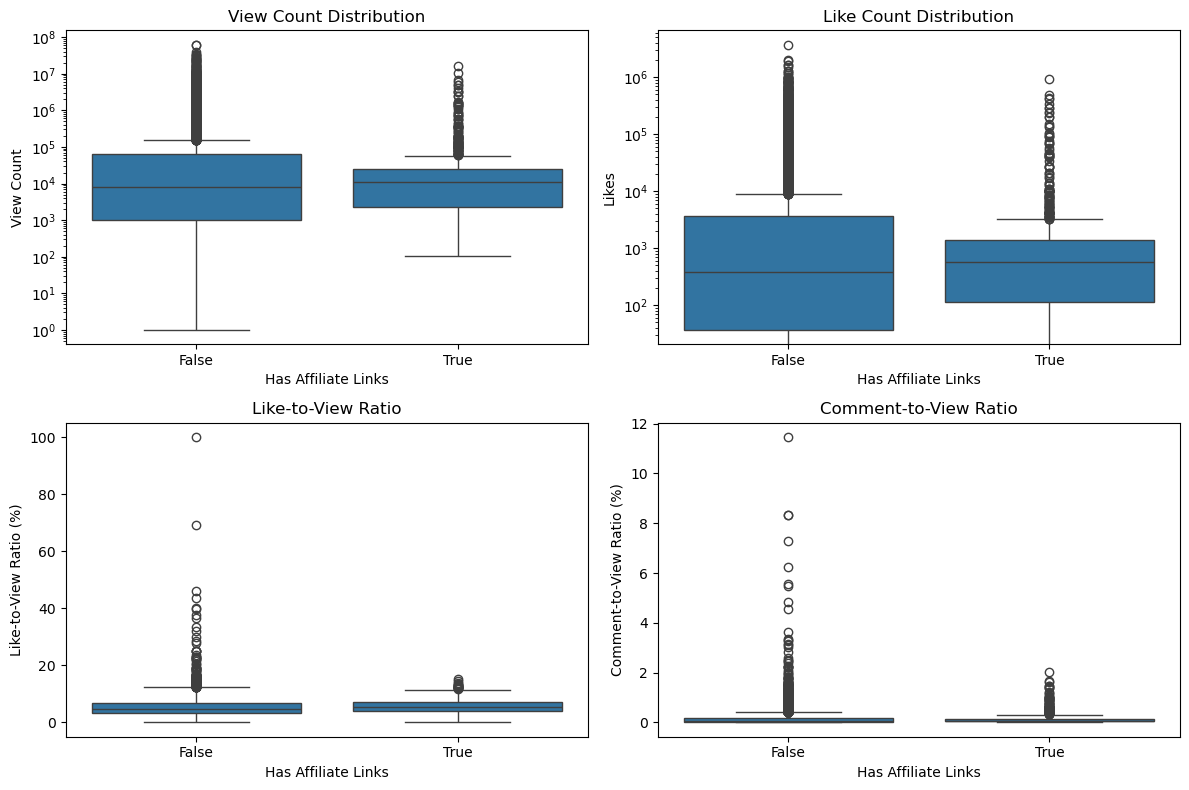

In [14]:
# plots for eda_p5
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.boxplot(x='has_any_affiliate', y='viewCount', data=df)
plt.title('View Count Distribution')
plt.xlabel('Has Affiliate Links')
plt.ylabel('View Count')
plt.yscale('log')  # Log scale helps with skewed distributions

plt.subplot(2, 2, 2)
sns.boxplot(x='has_any_affiliate', y='likes', data=df)
plt.title('Like Count Distribution')
plt.xlabel('Has Affiliate Links')
plt.ylabel('Likes')
plt.yscale('log')

plt.subplot(2, 2, 3)
sns.boxplot(x='has_any_affiliate', y='like_to_view_ratio', data=df)
plt.title('Like-to-View Ratio')
plt.xlabel('Has Affiliate Links')
plt.ylabel('Like-to-View Ratio (%)')

plt.subplot(2, 2, 4)
sns.boxplot(x='has_any_affiliate', y='comment_to_view_ratio', data=df)
plt.title('Comment-to-View Ratio')
plt.xlabel('Has Affiliate Links')
plt.ylabel('Comment-to-View Ratio (%)')

plt.tight_layout()
plt.savefig('affiliate_performance_comparison.png')
plt.show()

In [15]:
# eda_p6 : affiliate impact by channel size
df['subscriber_category'] = pd.cut(
    df['numberOfSubscribers'],
    bins=[0, 10000, 100000, 1000000, float('inf')],
    labels=['< 10K', '10K-100K', '100K-1M', '> 1M']
)

subscriber_impact = df.groupby(['subscriber_category', 'has_any_affiliate']).agg({
    'viewCount': 'mean',
    'like_to_view_ratio': 'mean'
}).reset_index()

print("\nAffiliate impact by channel size:")
print(subscriber_impact)

# eda_p7 : affiliate impact by verification status
verification_impact = df.groupby(['isChannelVerified', 'has_any_affiliate']).agg({
    'viewCount': 'mean',
    'like_to_view_ratio': 'mean'
}).reset_index()

print("\nAffiliate impact by verification status:")
print(verification_impact)


Affiliate impact by channel size:
  subscriber_category  has_any_affiliate     viewCount  like_to_view_ratio
0               < 10K              False  6.858517e+03            4.211572
1               < 10K               True  9.344429e+02            2.758403
2            10K-100K              False  2.712643e+04            4.779256
3            10K-100K               True  4.955512e+04            6.274606
4             100K-1M              False  1.898577e+05            6.969211
5             100K-1M               True  1.711311e+05            6.409897
6                > 1M              False  1.507303e+06            5.567244
7                > 1M               True  2.676919e+05            4.357050

Affiliate impact by verification status:
   isChannelVerified  has_any_affiliate      viewCount  like_to_view_ratio
0              False              False  112520.650807            5.155843
1              False               True  106324.788756            5.962805
2               True   

C:\Users\arubi\AppData\Local\Temp\ipykernel_20268\3784674496.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subscriber_impact = df.groupby(['subscriber_category', 'has_any_affiliate']).agg({


# Analysis 2 : Affiliate Links

- > Videos without affiliate links have a higher avg views 
- > T-test confirms this is statistically significant
- > Affiliate links seems to boost views and engagement for channels with subscribers in the range 10k-100k but negatively impact channels in other size categories

In [17]:
#eda : notebook 3 analyses
#eda_p8 : 
word_list = []
list_to_ignore = ["for","the","a","me","my","in","for","but","of","this","that","The","with","is","you","&","your","it","do","be","by","so","What","what","With","all","i","I","if","Why","why"]
list_to_ignore = set([word.lower() for word in list_to_ignore])
for _, row in df.iterrows():
    new_words = row["title"].split()
    word_list = word_list + [word.lower() for word in new_words if word not in list_to_ignore]


def compare_means(df, thing_to_check_for, thing_to_take_average_of, where_to_look="title"):
    print(f"Comparing means of {thing_to_take_average_of} with and without {thing_to_check_for}.")
    idxs = (df[where_to_look].str.count(thing_to_check_for) > 0)
    print(df.loc[idxs, thing_to_take_average_of].mean())
    print(df.loc[~idxs, thing_to_take_average_of].mean())

def get_mean_with_word(df, thing_to_check_for, thing_to_take_average_of, where_to_look="title"):
    idxs = (df[where_to_look].str.count(thing_to_check_for) > 0)
    return df.loc[idxs, thing_to_take_average_of].mean()

def get_mean_without_word(df, thing_to_check_for, thing_to_take_average_of, where_to_look="title"):
    idxs = (df[where_to_look].str.count(thing_to_check_for) == 0)
    return df.loc[idxs, thing_to_take_average_of].mean()

schema = pd.DataFrame()
words =["dupe","cheap","drugstore"]# add more words
column_to_take_average_of = "likes_per_subscriber"
where_to_look_for_word = "title"
schema["word"] = words
# Adds column, containing means of likes_per_subscriber of entries with the substring
schema['with_string'] = schema["word"].apply(lambda word : get_mean_with_word(df, word, column_to_take_average_of, where_to_look_for_word))
# Adds column, containing means of likes_per_subscriber of entries without the substring
schema['without_string'] = schema["word"].apply(lambda word : get_mean_without_word(df, word, column_to_take_average_of, where_to_look_for_word))
# Adds column, containing means of likes_per_subscriber of entries without the substring
schema['difference'] = schema['with_string']-df["likes_per_subscriber"].mean()

#finding diffrence between with and without substring
schema = schema.sort_values('difference', ascending=False)

print(df["likes_per_subscriber"].mean())

0.04248647407900561


In [18]:
#eda : notebook 4 analyses
#eda_p9 : ad impact
# subdf = df[['title', 'text', 'id', 'likes', 'viewCount', 'commentsCount', 'duration_in_seconds']]

# remove rows with NaN values
# subdf = subdf.dropna()
# print rows with 'ad' as a substring in the 'title' column or in the 'text' column
# DataFrame for rows where 'title' contains 'ad'
df['hasAdinTitle'] = df['title'].str.lower().str.contains('ad|sponsored|collaboration|promo|partner|affiliate|paid|gift', case=False, na=False).astype(int)
df['hasAdinText'] = df['text'].str.lower().str.contains('ad|sponsored|collaboration|promo|partner|affiliate|paid|gift', case=False, na=False).astype(int)

df_stats = df.groupby(['hasAdinTitle', 'hasAdinText'])[['viewCount', 'likes', 'commentsCount']].agg(['mean', 'median', 'count'])
# print(df_stats)

# t-test for viewCount
metrics = ['viewCount', 'likes', 'commentsCount']
for metric in metrics:
    t_stat, p_value = stats.ttest_ind(df.loc[df['hasAdinTitle'] == 1, metric], df.loc[df['hasAdinTitle'] == 0, metric], equal_var=False)
    print(f'T-test for {metric}: t-statistic = {t_stat}, p-value = {p_value}')
    t_stat_text, p_value_text = stats.ttest_ind(df.loc[df['hasAdinText'] == 1, metric], df.loc[df['hasAdinText'] == 0, metric], equal_var=False)
    print(f'T-test for {metric} by Ad in Text: t-statistic = {t_stat_text}, p-value = {p_value_text}')

#eda_p10 : duration impact on views, likes and comments
filtered_df = df[df['datetime_date'] >= '2024-10-15']
filtered_df['duration_bin'] = pd.cut(filtered_df['duration_in_seconds'], bins=[0, 30, 60, float('inf')], labels=['Short', 'Medium', 'Long'])

# Perform t-tests
for metric in metrics:
    for group1, group2 in [('Short', 'Medium'), ('Medium', 'Long'), ('Short', 'Long')]:
        t_stat, p_value = stats.ttest_ind(
            filtered_df.loc[filtered_df['duration_bin'] == group1, metric],
            filtered_df.loc[filtered_df['duration_bin'] == group2, metric],
            equal_var=False
        )
        print(f'T-test for {metric} ({group1} vs {group2}): t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}')

T-test for viewCount: t-statistic = 1.5282943313388886, p-value = 0.12679364807663276
T-test for viewCount by Ad in Text: t-statistic = -10.529889805368208, p-value = 9.657509645738969e-26
T-test for likes: t-statistic = 1.5211303847747835, p-value = 0.12857874702380206
T-test for likes by Ad in Text: t-statistic = -11.156795580460376, p-value = 1.222369987909289e-28
T-test for commentsCount: t-statistic = -1.1833139553744247, p-value = 0.23688462948653724
T-test for commentsCount by Ad in Text: t-statistic = -7.105187994459102, p-value = 1.3414356588159022e-12
T-test for viewCount (Short vs Medium): t-statistic = -3.0231, p-value = 0.0025
T-test for viewCount (Medium vs Long): t-statistic = 2.4124, p-value = 0.0160
T-test for viewCount (Short vs Long): t-statistic = -0.5793, p-value = 0.5625
T-test for likes (Short vs Medium): t-statistic = -4.2419, p-value = 0.0000
T-test for likes (Medium vs Long): t-statistic = 1.2525, p-value = 0.2107
T-test for likes (Short vs Long): t-statistic 

C:\Users\arubi\AppData\Local\Temp\ipykernel_20268\1961227954.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['duration_bin'] = pd.cut(filtered_df['duration_in_seconds'], bins=[0, 30, 60, float('inf')], labels=['Short', 'Medium', 'Long'])


In [19]:
# Calculate the new target variables
df['engagement_per_view'] = (df['likes'] + df['commentsCount']) / df['viewCount']
df['views_per_subscriber'] = df['viewCount'] / df['numberOfSubscribers']

# Perform t-tests for the new target variables
new_target_metrics = ['engagement_per_view', 'views_per_subscriber']
for metric in new_target_metrics:
    t_stat_title, p_value_title = stats.ttest_ind(
        df.loc[df['hasAdinTitle'] == 1, metric],
        df.loc[df['hasAdinTitle'] == 0, metric],
        equal_var=False
    )
    print(f'T-test for {metric} by Ad in Title: t-statistic = {t_stat_title:.4f}, p-value = {p_value_title:.4f}')
    
    t_stat_text, p_value_text = stats.ttest_ind(
        df.loc[df['hasAdinText'] == 1, metric],
        df.loc[df['hasAdinText'] == 0, metric],
        equal_var=False
    )
    print(f'T-test for {metric} by Ad in Text: t-statistic = {t_stat_text:.4f}, p-value = {p_value_text:.4f}')


T-test for engagement_per_view by Ad in Title: t-statistic = 0.2064, p-value = 0.8365
T-test for engagement_per_view by Ad in Text: t-statistic = -4.2140, p-value = 0.0000
T-test for views_per_subscriber by Ad in Title: t-statistic = -0.1807, p-value = 0.8566
T-test for views_per_subscriber by Ad in Text: t-statistic = -2.7198, p-value = 0.0065


# Analysis 3 : #Ad and video length 

- > Ad related strings in text statistically significantly reduces avg views, likes and comments
- > Ad related strings in title do not affect the metrics significantly
- > Medium length (30-60s) videos outperform other length videos in likes, views and comments
- > Both engagement and reach is statistically significantly affected in a negative way by having ad related info in the text

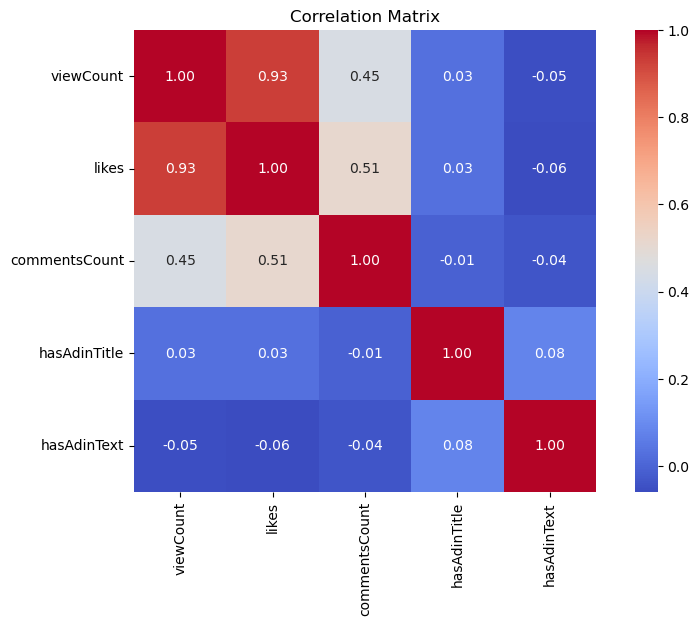

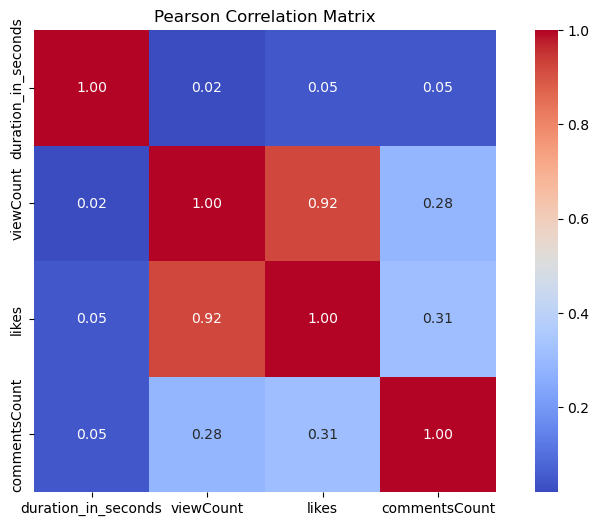

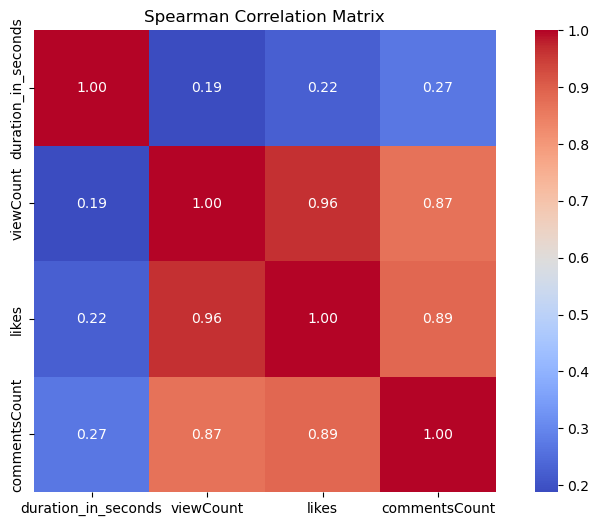

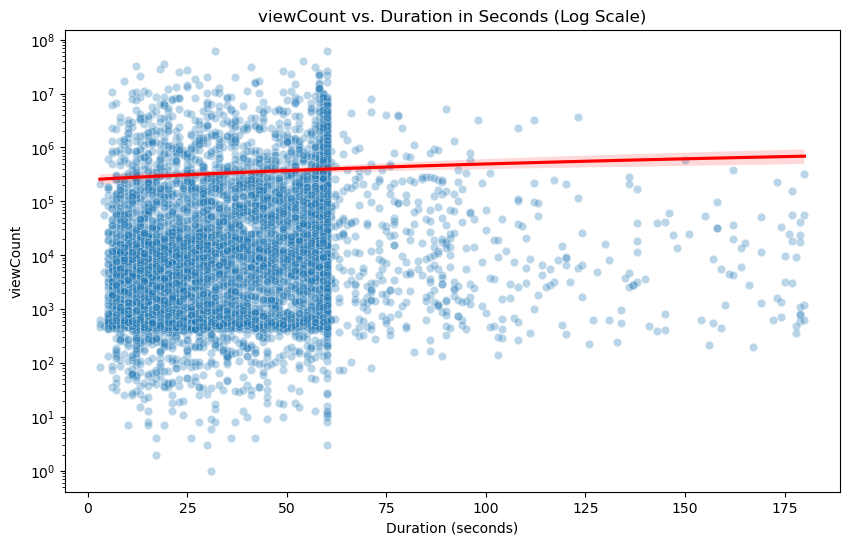

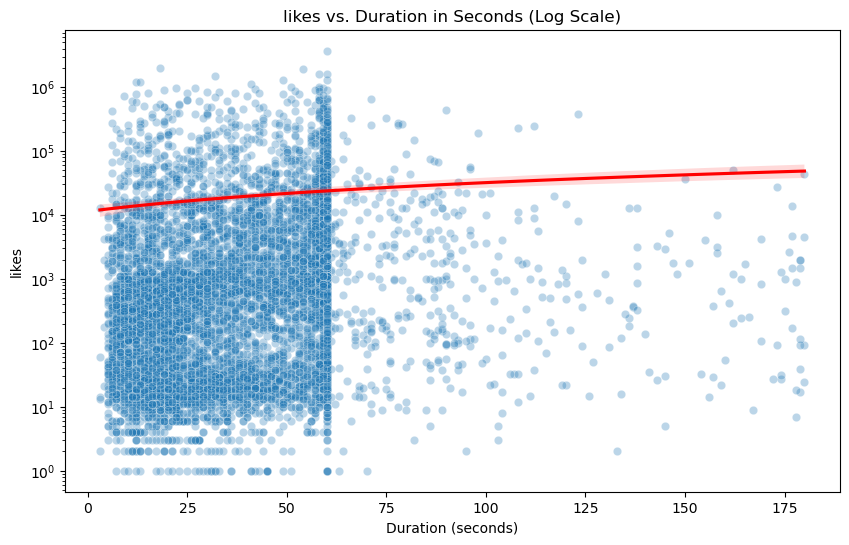

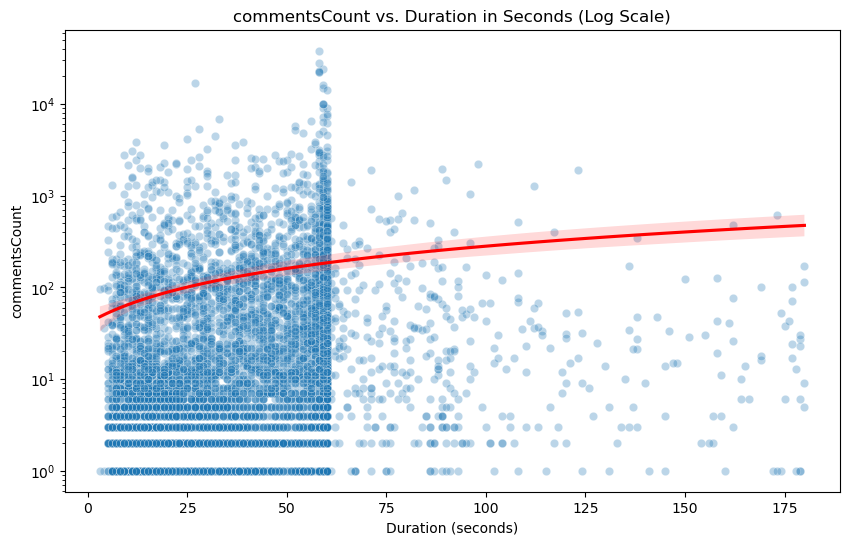

In [21]:
# plots for eda_p9
df_corr = df[['viewCount', 'likes', 'commentsCount', 'hasAdinTitle', 'hasAdinText']]

corr_matrix = df_corr.corr(method='pearson')
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix')
plt.show()

df_corr2 = filtered_df[['duration_in_seconds', 'viewCount', 'likes', 'commentsCount']]

pearson_corr = df_corr2.corr(method='pearson')
spearman_corr = df_corr2.corr(method='spearman')

# Plot Pearson correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Pearson Correlation Matrix')
plt.show()

# Plot Spearman correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Spearman Correlation Matrix')
plt.show()

for metric in ['viewCount', 'likes', 'commentsCount']:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='duration_in_seconds', y=metric, data=df, alpha=0.3)
    sns.regplot(x='duration_in_seconds', y=metric, data=df, scatter=False, color='red')
    plt.yscale('log')
    plt.title(f'{metric} vs. Duration in Seconds (Log Scale)')
    plt.xlabel('Duration (seconds)')
    plt.ylabel(metric)
    plt.show()

In [22]:
#eda : notebook 5 analyses
#eda_p11 : 

# Standardizing engagement-related variables
engagement_vars = ["likes", "commentsCount", "viewCount", "numberOfSubscribers"]

# Apply Z-score standardization
for var in engagement_vars:
    df[f"{var}_std"] = zscore(df[var])

# I will also compute two engagement metrics:
# Engagement per Subscriber (to assess subscriber loyalty, but won't reflect new viewers' interactions)
# and Engagement per View (to assess how engaging the content is to viewers, but this can be influenced by algorithms)
df["Engagement_per_Subscriber"] = (df["likes"] + df["commentsCount"]) / (df["numberOfSubscribers"] + 1)
df["Engagement_per_View"] = (df["likes"] + df["commentsCount"]) / (df["viewCount"] + 1)


# Ensure no NaN or infinite values in the engagement metrics
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=["Engagement_per_Subscriber", "Engagement_per_View"], inplace=True)

verified = df[df["isChannelVerified"] == True].copy()
non_verified = df[df["isChannelVerified"] == False].copy()

# Compute T-tests and Effect Sizes (Cohen's d)
t_test_results = { "Metric": [], "T-test p-value": [], "Effect Size (Cohen's d)": []}

def cohen_d(x, y):
    return (np.mean(x) - np.mean(y)) / np.sqrt((np.var(x, ddof=1) + np.var(y, ddof=1)) / 2)

for metric in ["likes_std", "commentsCount_std", "viewCount_std", "numberOfSubscribers_std", "Engagement_per_Subscriber", "Engagement_per_View"]:
    ttest_p = ttest_ind(verified[metric], non_verified[metric], nan_policy='omit').pvalue
    d_value = cohen_d(verified[metric].dropna(), non_verified[metric].dropna())

    t_test_results["Metric"].append(metric)
    t_test_results["T-test p-value"].append(ttest_p)
    t_test_results["Effect Size (Cohen's d)"].append(d_value)

# Convert to DataFrame and display results
t_test_df = pd.DataFrame(t_test_results)
t_test_df

,Metric,T-test p-value,Effect Size (Cohen's d)
0,likes_std,6.629107e-52,0.306993
1,commentsCount_std,7.106330e-40,0.260477
2,viewCount_std,1.489768e-48,0.293709
3,numberOfSubscribers_std,0.000000e+00,0.878495
4,Engagement_per_Subscriber,1.550415e-02,-0.066184
5,Engagement_per_View,5.835396e-21,0.234962


# Analysis 4 : Verified ?

- > Videos from verified channels have significantly more likes, views, comments, engagement and subscribers than those from non-verified channels

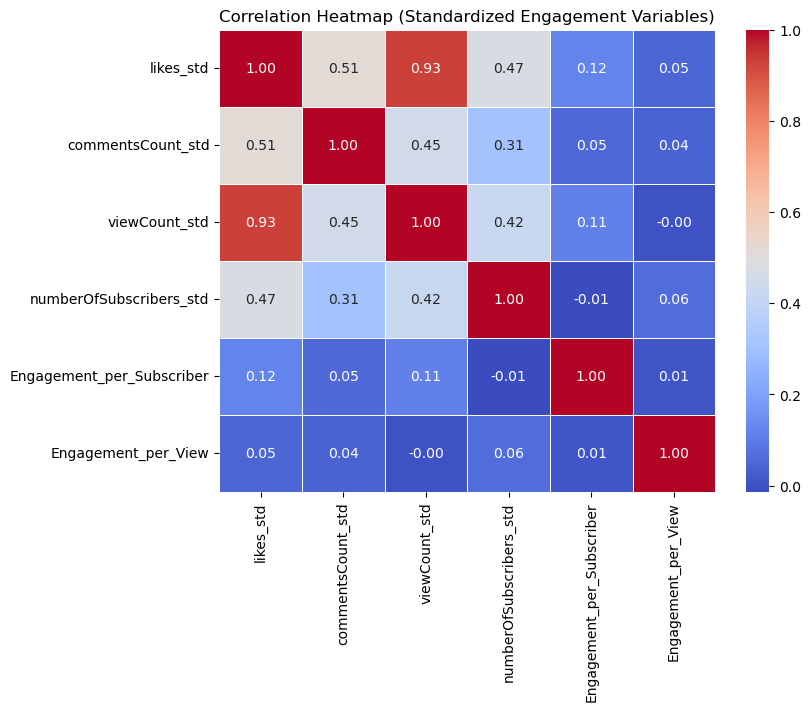

C:\Users\arubi\AppData\Local\Temp\ipykernel_20268\2888419894.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["isChannelVerified"], y=df["likes_std"], showfliers=False, ax=axes[0, 0], palette=["blue", "red"])
C:\Users\arubi\AppData\Local\Temp\ipykernel_20268\2888419894.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["isChannelVerified"], y=df["commentsCount_std"], showfliers=False, ax=axes[0, 1], palette=["blue", "red"])
C:\Users\arubi\AppData\Local\Temp\ipykernel_20268\2888419894.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  s

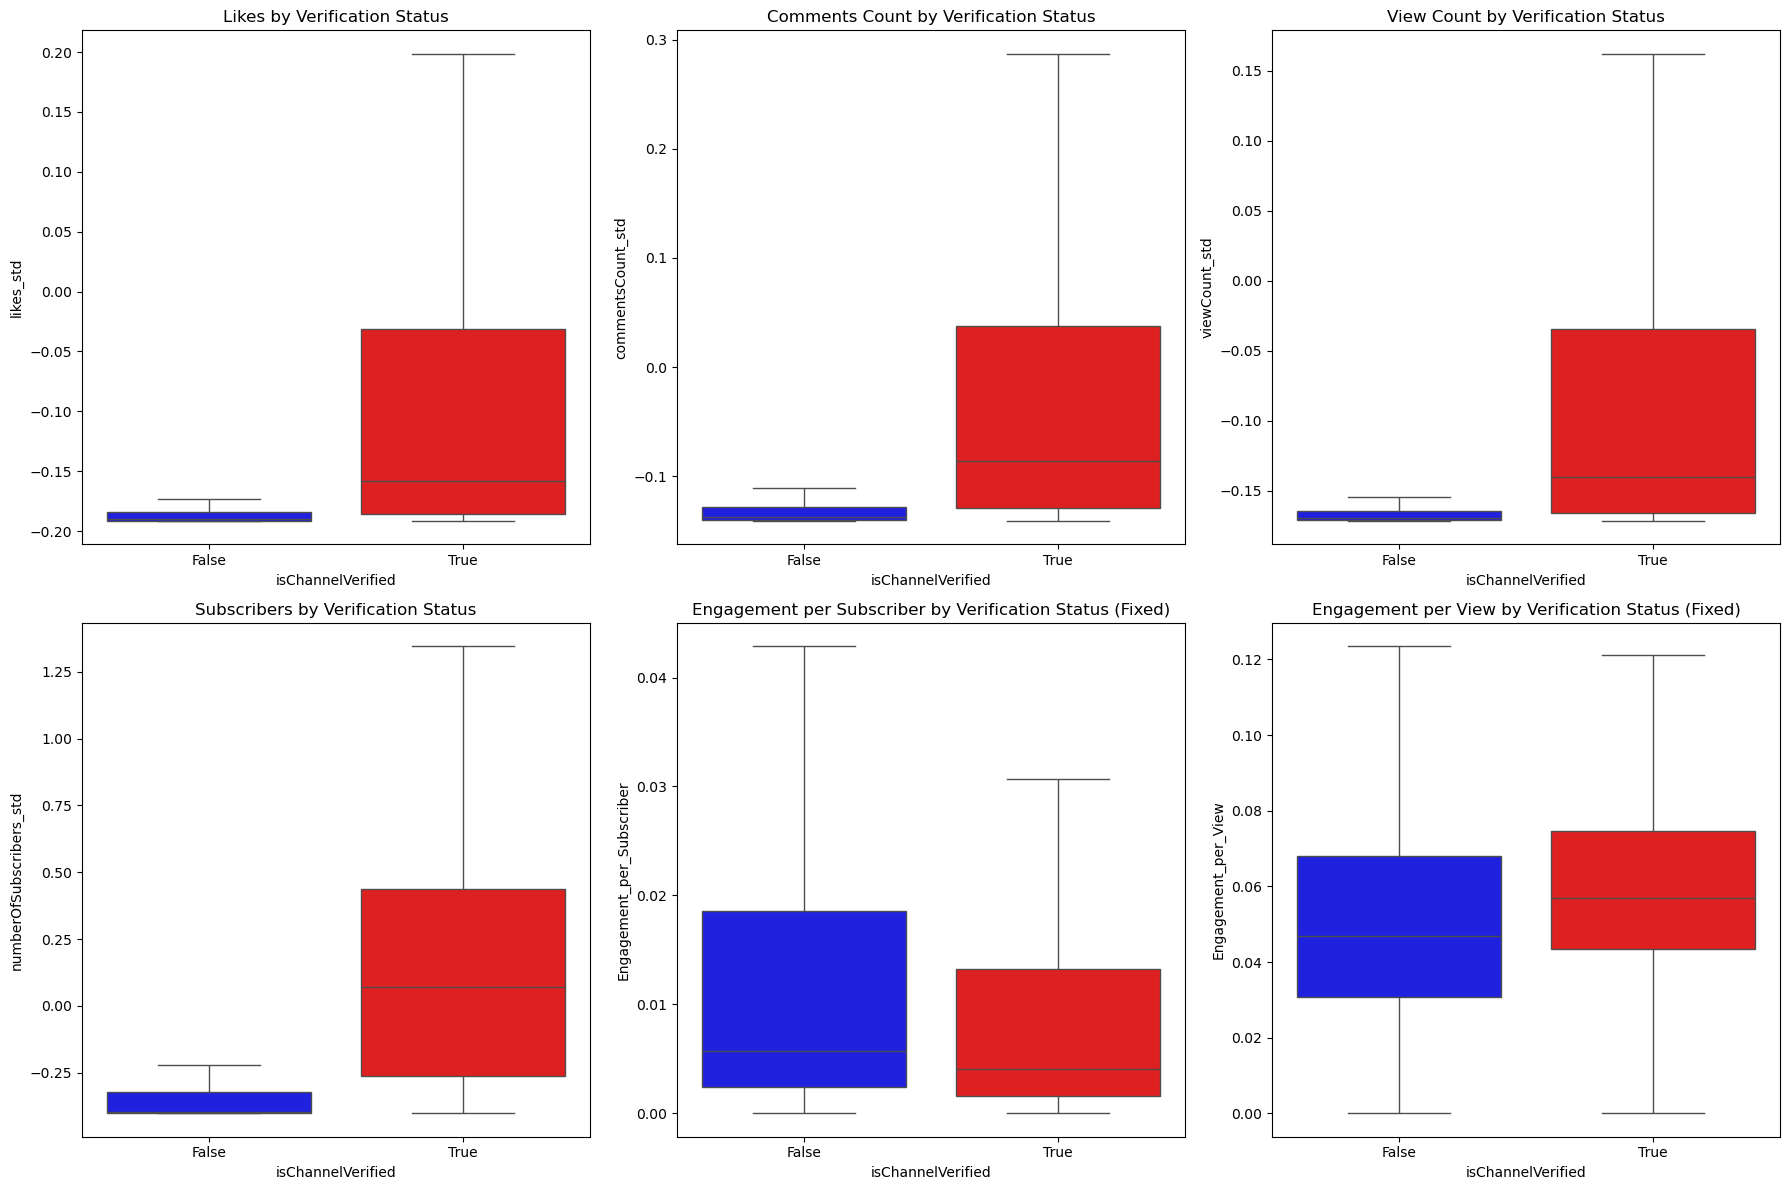

In [24]:
#plot for eda_p11
# Compute correlation matrix for engagement-related variables to assess multicollinearity
correlation_matrix = df[["likes_std", "commentsCount_std", "viewCount_std", "numberOfSubscribers_std", "Engagement_per_Subscriber","Engagement_per_View"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Standardized Engagement Variables)")
plt.show()


# Boxplots for standardized engagement variables
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

sns.boxplot(x=df["isChannelVerified"], y=df["likes_std"], showfliers=False, ax=axes[0, 0], palette=["blue", "red"])
axes[0, 0].set_title("Likes by Verification Status")

sns.boxplot(x=df["isChannelVerified"], y=df["commentsCount_std"], showfliers=False, ax=axes[0, 1], palette=["blue", "red"])
axes[0, 1].set_title("Comments Count by Verification Status")

sns.boxplot(x=df["isChannelVerified"], y=df["viewCount_std"], showfliers=False, ax=axes[0, 2], palette=["blue", "red"])
axes[0, 2].set_title("View Count by Verification Status")

sns.boxplot(x=df["isChannelVerified"], y=df["numberOfSubscribers_std"], showfliers=False, ax=axes[1, 0], palette=["blue", "red"])
axes[1, 0].set_title("Subscribers by Verification Status")

sns.boxplot(x=df["isChannelVerified"], y=df["Engagement_per_Subscriber"], showfliers=False, ax=axes[1, 1], palette=["blue", "red"])
axes[1, 1].set_title("Engagement per Subscriber by Verification Status (Fixed)")

sns.boxplot(x=df["isChannelVerified"], y=df["Engagement_per_View"], showfliers=False, ax=axes[1, 2], palette=["blue", "red"])
axes[1, 2].set_title("Engagement per View by Verification Status (Fixed)")

plt.tight_layout()
plt.show()

In [ ]:
#Analysis 6

In [25]:
#eda : notebook 6 analyses
#eda_p12 : impact of time of day, month
df1 = df.copy()

df1['datetime'] = pd.to_datetime(df['date'])

df1['hour'] = df1['datetime'].dt.hour
df1['day_of_week'] = df1['datetime'].dt.dayofweek  # 0 is Monday, 6 is Sunday
df1['month'] = df1['datetime'].dt.month
df1['year'] = df1['datetime'].dt.year

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df1['day_name'] = df1['day_of_week'].apply(lambda x: day_names[int(x)] if pd.notnull(x) else None)

numeric_columns = ['viewCount', 'likes', 'commentsCount', 'hour', 'day_of_week', 'month', 'year']
numeric_df = df1[numeric_columns].copy()

df1['engagement_rate'] = (df1['likes'] + df1['commentsCount']) / df1['viewCount'] * 100

monthly_metrics = df1.groupby('month').agg({
    'engagement_rate': 'mean'
}).reset_index()

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_metrics['month_name'] = monthly_metrics['month'].apply(lambda x: month_names[int(x)-1] if pd.notnull(x) else None)
hourly_metrics = df1.groupby('hour').agg({
    'engagement_rate': 'mean'
}).reset_index()

hourly_metrics['hour_label'] = hourly_metrics['hour'].apply(lambda x: f"{int(x)}:00")

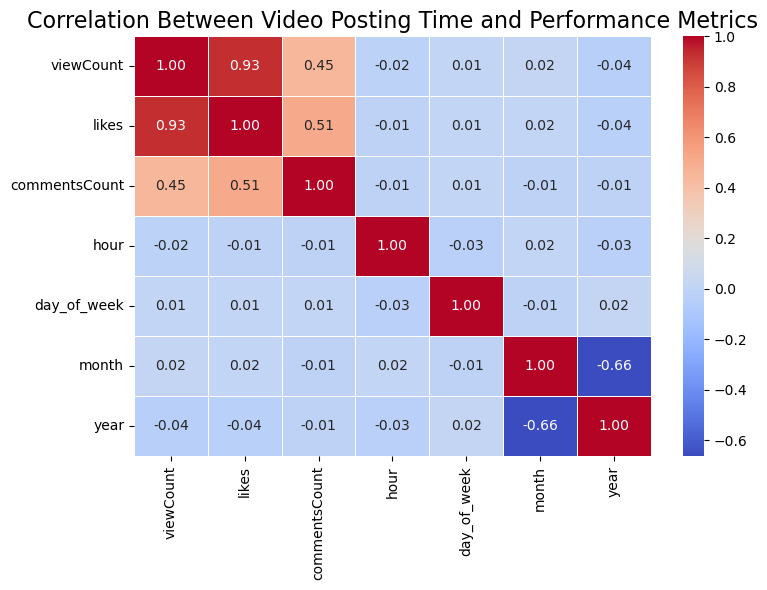

C:\Users\arubi\AppData\Local\Temp\ipykernel_20268\2760438923.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\arubi\AppData\Local\Temp\ipykernel_20268\2760438923.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\arubi\AppData\Local\Temp\ipykernel_20268\2760438923.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


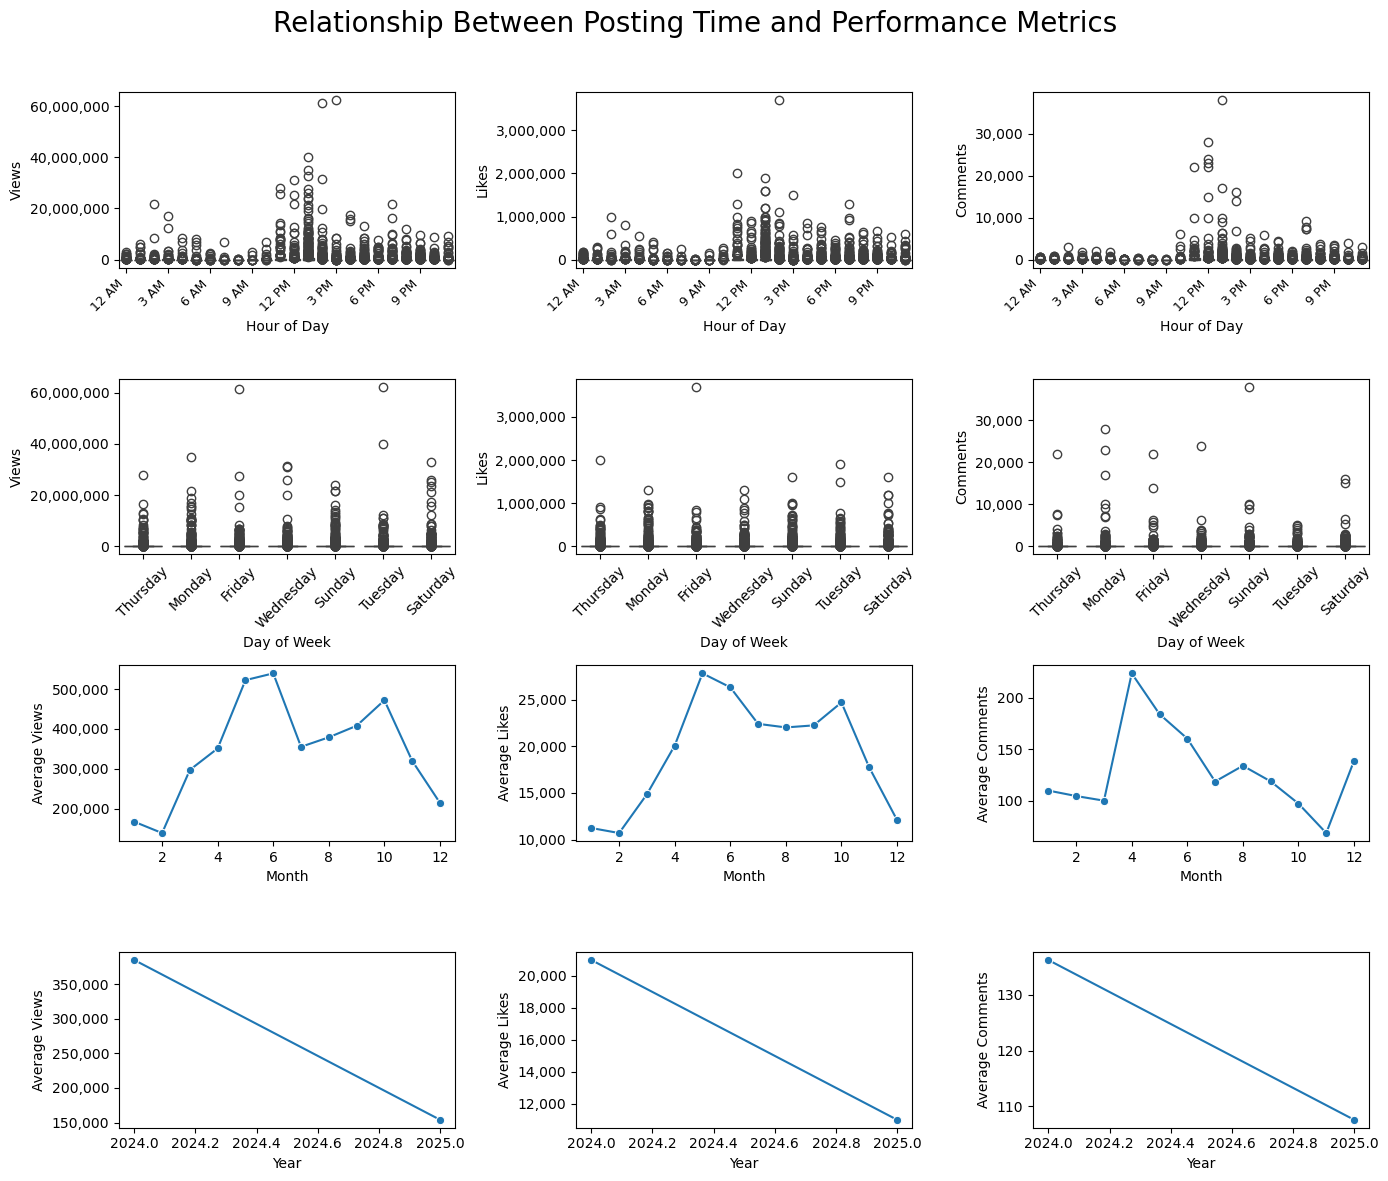

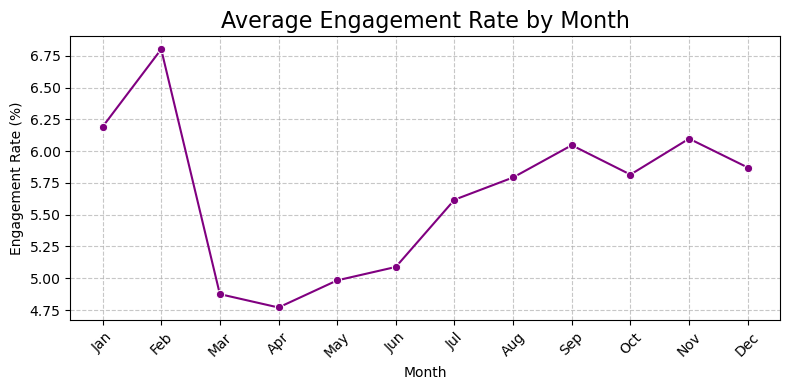

Best month for engagement: Feb (6.80% engagement rate)


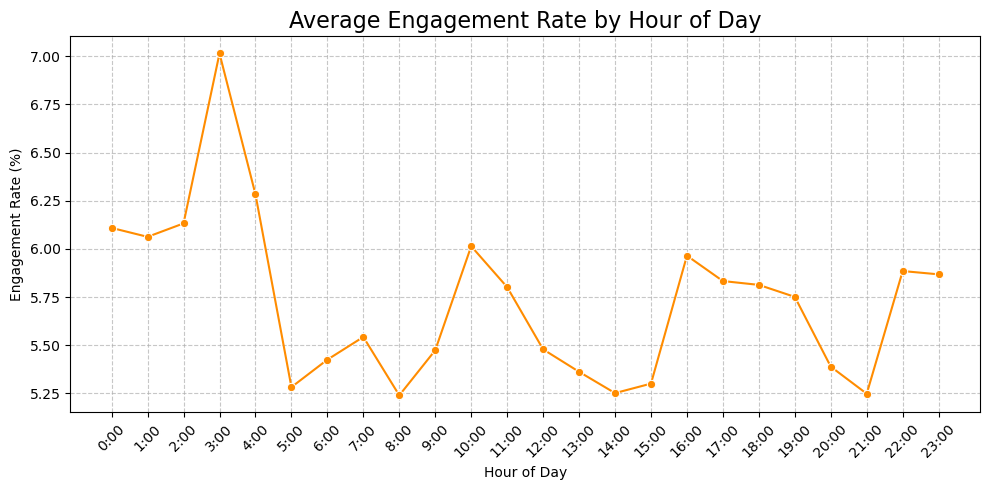

Best hour for engagement: 3:00 (7.01% engagement rate)


In [26]:
# plot for eda_p12
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Between Video Posting Time and Performance Metrics', fontsize=16)
plt.tight_layout()
# plt.savefig('time_correlation_heatmap.png')
plt.show()

time_elements = ['hour', 'day_of_week', 'month', 'year']
performance_metrics = ['viewCount', 'likes', 'commentsCount']

fig, axes = plt.subplots(len(time_elements), len(performance_metrics), figsize=(14, 12))
fig.suptitle('Relationship Between Posting Time and Performance Metrics', fontsize=20)

for i, time_element in enumerate(time_elements):
    for j, metric in enumerate(performance_metrics):
        ax = axes[i, j]

        if time_element in ['hour', 'day_of_week']:
            if time_element == 'day_of_week':
                temp_df = df1.copy()
                temp_df['day_category'] = temp_df['day_name']
                sns.boxplot(x='day_category', y=metric, data=temp_df, ax=ax)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

            else:
                sns.boxplot(x=time_element, y=metric, data=df1, ax=ax)

                hour_ticks = range(0, 24, 3)  # Show every 3 hours
                hour_labels = []
                for h in hour_ticks:
                    if h == 0:
                        hour_labels.append("12 AM")
                    elif h < 12:
                        hour_labels.append(f"{h} AM")
                    elif h == 12:
                        hour_labels.append("12 PM")
                    else:
                        hour_labels.append(f"{h-12} PM")

                ax.set_xticks(hour_ticks)
                ax.set_xticklabels(hour_labels, rotation=45, ha='right', fontsize=9)

            if metric == 'viewCount':
                ax.set_ylabel('Views')
            elif metric == 'commentsCount':
                ax.set_ylabel('Comments')
            else:
                ax.set_ylabel(metric.capitalize())

            if time_element == 'hour':
                ax.set_xlabel('Hour of Day')
            elif time_element == 'day_of_week':
                ax.set_xlabel('Day of Week')
            else:
                ax.set_xlabel(time_element.capitalize())

            ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f'{int(x):,}' if x >= 1000 else f'{int(x)}'))

        else:
            grouped = df1.groupby(time_element)[metric].mean().reset_index()
            sns.lineplot(x=time_element, y=metric, data=grouped, marker='o', ax=ax)

            if metric == 'viewCount':
                ax.set_ylabel('Average Views')
            elif metric == 'commentsCount':
                ax.set_ylabel('Average Comments')
            else:
                ax.set_ylabel(f'Average {metric.capitalize()}')

            ax.set_xlabel(time_element.capitalize())

            ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f'{int(x):,}' if x >= 1000 else f'{int(x)}'))

plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.savefig('time_performance_relationships.png')
plt.show()

plt.figure(figsize=(8, 4))
sns.lineplot(x='month_name', y='engagement_rate', data=monthly_metrics, marker='o', color='purple')
plt.title('Average Engagement Rate by Month', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Engagement Rate (%)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig('engagement_by_month.png')
plt.show()

best_month_engagement = monthly_metrics.loc[monthly_metrics['engagement_rate'].idxmax()]
print(f"Best month for engagement: {best_month_engagement['month_name']} ({best_month_engagement['engagement_rate']:.2f}% engagement rate)")

plt.figure(figsize=(10, 5))
sns.lineplot(x='hour_label', y='engagement_rate', data=hourly_metrics, marker='o', color='darkorange')
plt.title('Average Engagement Rate by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day')
plt.ylabel('Engagement Rate (%)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
# plt.savefig('engagement_by_hour.png')
plt.show()

best_hour_engagement = hourly_metrics.loc[hourly_metrics['engagement_rate'].idxmax()]
print(f"Best hour for engagement: {int(best_hour_engagement['hour'])}:00 ({best_hour_engagement['engagement_rate']:.2f}% engagement rate)")

Analysis 7

In the following section we will see if mentioning a popular brand has an impact on post performance. 
We have hand-selected 30 popular beauty brands; 15 of these are skincare brands and 15 of these are makeup brands. This list is subjective and may not be exhaustive but should cover a good number of popular brands. 

Brands:
Makeup:
1) Natasha Denona
2) Tower 28
3) Pat McGrath
4) Urban Decay
5) ColourPop
6) Fenty Beauty
7) E.L.F. cosmetics
8) Nyx professional makeup
9) Essence
10) Benefit Cosmetics
11) Anastasia Beverly Hills
12) Tarte
13) Milk Makeup
14) Maybelline
15) Oden's Eye

Skincare:
1) The Ordinary
2) Beauty of Josean
3) Bubble
4) Paula's Choice
5) Cerave
6) Good Molecules
7) Cosrx
8) Olive Young
9) Dennis Grossman
10) Skinfix
11) Drunk Elephant
12) La Roche-Posay
13) Supergoop
14) Glow Recipe
15) Rhode

In [28]:
#eda : notebook 7 analyses
#eda_p13 : brand impact

mentions = ["natasha denona", "natashadenona", "denona", "tower 28", "tower28", "pat mcgrath", "pmg labs", "mcgrath", "patmcgrath"]
mentions += ["urban decay", "urbandecay", "colourpop", "colorpop", "colour pop", "fenty", "e.l.f.", "elf", "nyx", "essence", "benefit"]
mentions += ["anastasia", "abh", "tarte", "milk", "maybelline", "oden's eye", "oden'seye", "odenseye", "the ordinary", "theordinary"]
mentions += ["beauty of josean", "josean", "bubble", "paula's choice", "paula'schoice", "paulaschoice", "cerave", "good molecules"]
mentions += ["cosrx", "olive young", "oliveyoung", "grossman", "skinfix", "drunk elephant", "drunkelephant", "roche-posay", "roche posay", "rocheposay"]
mentions += ["supergoop", "glow recipe", "glowrecipe", "rhode"]
text_list = []

for item in df["text"]:
    x = item if type(item) == str else '' 
    text_list.append(x)

df["text"] = np.array(text_list)
df["title plus desc"] = df["title"] + df["text"] #Creating a single column of both title and description so that my for loop works in the next step. 

popb_list = []
for item in df["title plus desc"]:
    item = item.lower()

    ment_bool = False
    for ment in mentions:
        if (ment in item):
            ment_bool = True

    popb_list.append(ment_bool) 
    
df["popular_brand"] = np.array(popb_list) 
df_yes = df.loc[  df["popular_brand"] == True]
df_no = df.loc[  df["popular_brand"] == False]
# # Replace whitespaces in column names with underscores
# df.columns = df.columns.str.replace(' ', '_')

print(df_yes["views_per_subscriber"].mean())
print(df_no["views_per_subscriber"].mean())
print(df["views_per_subscriber"].mean())
print(df_yes["likes_per_subscriber"].mean())
print(df_no["likes_per_subscriber"].mean())
print(df["likes_per_subscriber"].mean())
print(df_yes["comments_per_subscriber"].mean())
print(df_no["comments_per_subscriber"].mean())
print(df["comments_per_subscriber"].mean())

1.9040020843261454
0.7610972067437473
0.9433975185768472
0.059172658558904585
0.03931982596754524
0.04248647407900561
0.0005353636478498052
0.00046479661517013956
0.00047605248809094795


Here are my initial thoughts based on the analysis: Mentioning popular brands seems to significantly improve views. It seems to improves likes/comments, but not necessarily significantly. This is quite strange! One reason for this might be because these posts tend to mention popular brands in hashtags, which improve views, even though people overall are not more likely to comment or like on your post just because you mentioned a popular brand.

In [30]:
t_stat, p_value = stats.ttest_ind(df_yes["views_per_subscriber"], df_no["views_per_subscriber"] ) 
print(p_value/2) #We are really doing a one-tailed t-test so we divide the p-value by 2. 
print(t_stat)

0.005443751267405046
2.546889441241137


The above t-test seems to indicate that yes, posts which mention a popular brand tend to have higher views on average.
I would recommend a simialar t-test be done on the testing set for our final analysis. 

In [32]:
#eda : notebook 8 analyses
#eda_p14 : prime time

df1 = df.copy()

df1['datetime'] = pd.to_datetime(df['date'])

df1['hour'] = df1['datetime'].dt.hour
df1['day_of_week'] = df1['datetime'].dt.dayofweek  # 0 is Monday, 6 is Sunday
df1['month'] = df1['datetime'].dt.month
df1['year'] = df1['datetime'].dt.year

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df1['day_name'] = df1['day_of_week'].apply(lambda x: day_names[int(x)] if pd.notnull(x) else None)

numeric_columns = ['viewCount', 'likes', 'commentsCount', 'hour', 'day_of_week', 'month', 'year']
numeric_df = df1[numeric_columns].copy()

df1['engagement_rate'] = (df1['likes'] + df1['commentsCount']) / df1['viewCount'] * 100

monthly_metrics = df1.groupby('month').agg({
    'engagement_rate': 'mean'
}).reset_index()

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_metrics['month_name'] = monthly_metrics['month'].apply(lambda x: month_names[int(x)-1] if pd.notnull(x) else None)
# Group data by hour and create lists of engagement rates for each hour
hour_groups = [df1[df1['hour'] == hour]['engagement_rate'].values for hour in range(24)]
# Remove any empty groups
hour_groups = [group for group in hour_groups if len(group) > 0]


f_stat, p_value = f_oneway(*hour_groups)
print(f"ANOVA results: F-statistic = {f_stat}, p-value = {p_value}")
print(f"Hours significantly affect engagement rate: {p_value < 0.05}")

# 2. Pairwise t-tests
df_for_tukey = df1[['hour', 'engagement_rate']].copy()
df_for_tukey['hour'] = df_for_tukey['hour'].astype(str)  # Convert hour to string for the test

tukey_results = pairwise_tukeyhsd(
    df_for_tukey['engagement_rate'],
    df_for_tukey['hour'],
    alpha=0.05
)

print(tukey_results)


prime_hours = [3, 4, 10, 11, 16, 17, 18, 19, 22, 23]

prime_engagement = df1[df1['hour'].isin(prime_hours)]['engagement_rate']
non_prime_engagement = df1[~df1['hour'].isin(prime_hours)]['engagement_rate']

# Perform t-test
t_stat, p_value = stats.ttest_ind(prime_engagement, non_prime_engagement, equal_var=False)
print(f"T-test results (prime vs non-prime): t-statistic = {t_stat}, p-value = {p_value}")
print(f"Prime time hours significantly differ from non-prime: {p_value < 0.05}")


mean_diff = prime_engagement.mean() - non_prime_engagement.mean()
pooled_std = np.sqrt(((len(prime_engagement) - 1) * prime_engagement.std()**2 +
                     (len(non_prime_engagement) - 1) * non_prime_engagement.std()**2) /
                     (len(prime_engagement) + len(non_prime_engagement) - 2))
cohens_d = mean_diff / pooled_std

print(f"Mean engagement difference: {mean_diff:.2f} percentage points")
print(f"Cohen's d (effect size): {cohens_d:.2f}")

df1.copy()

df['datetime'] = pd.to_datetime(df['date'])
df['hour'] = df['datetime'].dt.hour
df["prime_hour"] = df['hour'].isin(prime_hours)

ANOVA results: F-statistic = 3.666030254122023, p-value = 7.105490979555409e-09
Hours significantly affect engagement rate: True


C:\Users\arubi\anaconda3\envs\erdos_spring_2025\Lib\site-packages\scipy\integrate\_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.0464    1.0 -1.2384  1.1456  False
     0     10   -0.095    1.0 -1.7674  1.5774  False
     0     11  -0.3074    1.0 -1.5502  0.9354  False
     0     12  -0.6304 0.9605 -1.8099  0.5491  False
     0     13  -0.7469 0.5081 -1.7497  0.2559  False
     0     14  -0.8575 0.1259 -1.7921  0.0771  False
     0     15  -0.8083 0.2727 -1.7776   0.161  False
     0     16  -0.1442    1.0  -1.123  0.8347  False
     0     17  -0.2759    1.0  -1.229  0.6772  False
     0     18  -0.2958    1.0 -1.2731  0.6816  False
     0     19  -0.3581 0.9998 -1.3379  0.6217  False
     0      2   0.0234    1.0 -1.2067  1.2535  False
     0     20  -0.7203 0.5932 -1.7265  0.2859  False
     0     21  -0.8608 0.2392 -1.8741  0.1525  False
     0     22  -0.2239    1.0 -1.2746  0.8267  False
     0     23  -0.2411    1.0 -1.3305  0.8484 

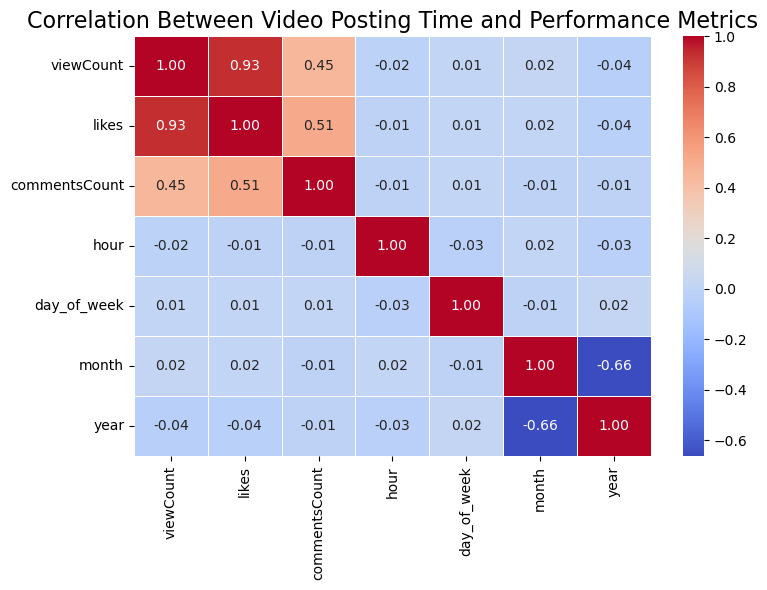

In [33]:
#plot for eda_p14
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Between Video Posting Time and Performance Metrics', fontsize=16)
plt.tight_layout()
plt.savefig('time_correlation_heatmap.png')
plt.show()



# Analysis 8 - Keywords

- > Summary of results: Posts with keywords in the "korean", "speed", and "product" keyword groups seem to perform well with regard to likes/subscriber and views/subscriber, with "korean" being the top performer.


In the following section, we will check to see which keywords are good to use in the title and/or description to boost performance metrics.

In [34]:
#eda_p15: Keyword Analysis

#Here I was trying to see if there were any titles that were repeated. 
#What I noticed was that certain content creators have their own theme/running series of videos that they label with specific titles.
#AtarahMayhew uses "I 👅 U" as the title for any video where she swallows a piece of paper after doing her makeup
#AtarahMayhew has a series of "CUTE ✅ or FAIL? ❌ Tiktok Filters Pick My Makeup 😱"
#Julia.P uses "Dior lip maximizer", "Kiko Milano lip gloss", 'New Dior lipstick', 'Fenty beauty lip oil','Queen Musia lipstick'! 
# where shes just showing the packaging with viral transition sounds or songs playing over the audio
#alot of swatches, but sort of low-effort, with no description etc
#nats_tutorials seems to have a running series of "testing a weird ____" which results in several videos of the same title
#lifebyjessica1 has a running series of "dollar store finds"
#lindseyteaches has a running series of teacher hairstyles of the day
#SofiaSeesBeauty was spamming her new brush set/using the title as an advertisement 
#blueyoobin has a 5 step skincare series

#the main offenders for title repetition (they have more than one series running) are: AtarahMayhew, Julia.P, nats_tutorials

counts = df['title'].value_counts()
with pd.option_context("display.max_rows", None):
    display(counts)

title
Take off my makeup with me! 🫧                                                                           6
CUTE ✅ or FAIL? ❌ Tiktok Filters Pick My Makeup 😱                                                       6
Dior single eyeshadow                                                                                   4
I 👅 U                                                                                                   4
The BEST Drugstore Tweezers                                                                             4
5-step skincare                                                                                         4
Pat McGrath satin lipstick #springonshorts                                                              3
Testing Vintage Tweezers                                                                                3
Dollarstore Finds 👀 #dollarstore #dollarstorefinds #dollarstoremusthaves #dollarama #dollaramafinds     3
Fenty beauty lip oil                    

In [60]:
#I was wondering if there were keywords I wasn't thinking of - just from some bias I have, so instead I search for all words used in every title
#And order them by frequency. 
#I then tried to remove the obvious articles and conjunctions, but somes still come through, maybe some blank space or smthn subtle? 

word_list = []
list_to_ignore = ["for","the","a","me","my","in","for","but","of","this","that","The","with","is","you","&","your","it","do","be","by","so","What","what","With","all","i","I","if","Why","why"]
list_to_ignore = set([word.lower() for word in list_to_ignore])
for _, row in df.iterrows():
    new_words = row["title"].split()
    word_list = word_list + [word.lower() for word in new_words if word not in list_to_ignore]

with pd.option_context("display.max_rows", None):
    display(pd.Series(word_list).value_counts())

#makeup                                             904
to                                                  804
makeup                                              804
#shorts                                             761
#skincare                                           639
lip                                                 604
#beauty                                             426
i                                                   414
the                                                 407
new                                                 389
how                                                 381
#kbeauty                                            380
skin                                                379
part                                                352
skincare                                            340
beauty                                              336
on                                                  314
and                                             

In [62]:
#streamlining the "presence of a substring" function Rachael was implementing earlier - Jo

def compare_means(df, thing_to_check_for, thing_to_take_average_of, where_to_look="title"):
    print(f"Comparing means of {thing_to_take_average_of} with and without {thing_to_check_for}.")
    idxs = (df[where_to_look].str.count(thing_to_check_for) > 0)
    print(df.loc[idxs, thing_to_take_average_of].mean())
    print(df.loc[~idxs, thing_to_take_average_of].mean())

def get_mean_with_word(df, thing_to_check_for, thing_to_take_average_of, where_to_look="title"):
    idxs = (df[where_to_look].str.count(thing_to_check_for) > 0)
    return df.loc[idxs, thing_to_take_average_of].mean()

def get_mean_without_word(df, thing_to_check_for, thing_to_take_average_of, where_to_look="title"):
    idxs = (df[where_to_look].str.count(thing_to_check_for) == 0)
    return df.loc[idxs, thing_to_take_average_of].mean()

# Identify popular video topics/formats and see if videos that cover these topics perform better than average. 
# For example, one popular video format is "speed reviews."
#"speed reviews", "haul", "dupe" , "GRWM"  etc


# Create a dataframe
schema = pd.DataFrame()

words =["dupe","cheap","drugstore"]# add more words
column_to_take_average_of = "likes_per_subscriber"
where_to_look_for_word = "title"

#added color vs colour to see if there was an american bias
#try vs tryon, since try includes both tryon, as well as "trying" 
#celebrity names to see if people want to copy signature looks?
#asmr, grwm, vlog have secondary content separate from the objective makeup 
#retail stores to see if people are looking to purchase
#ten - trying to see if people like lists? i.e. "my top ten"

schema["word"] = words


# Adds column, containing means of likes_per_subscriber of entries with the substring
schema['with_string'] = schema["word"].apply(lambda word : get_mean_with_word(df, word, column_to_take_average_of, where_to_look_for_word))

# Adds column, containing means of likes_per_subscriber of entries without the substring
schema['without_string'] = schema["word"].apply(lambda word : get_mean_without_word(df, word, column_to_take_average_of, where_to_look_for_word))


# Adds column, containing means of likes_per_subscriber of entries without the substring
schema['difference'] = schema['with_string']-df["likes_per_subscriber"].mean()


#finding diffrence between with and without substring

schema = schema.sort_values('difference', ascending=False)

# show dataframe 

print(df["likes_per_subscriber"].mean())
display(schema)

0.04248647407900561


,word,with_string,without_string,difference
2,drugstore,0.157164,0.041906,0.114678
0,dupe,0.065891,0.042401,0.023405
1,cheap,NaN,0.042486,NaN


In [74]:
#keyword groups
comparison_list = ["unbox","haul","review","try","vs"]
skills_list=["tip","trick","hack","tutorial"]
skincare_list = ["skincare","mask","toner"]#"sunscreen","acne","clean","snail","serum"
product_list=["tint","lipgloss","blush","balm","foundation","lipstick","concealer","eyeshadow","mascara","oil"] #
speed_list=["short","speed","quick","fast","routine"]
#adjective_list=["color","colour","shade","swatch"]
#brand_noun_list=["fenty","dior"]
budget_list=["dupe","cheap","drugstore"] #"budget","affordable"
self_ref_list=["viral","short","popular","fav","best","cute","easy","trend","makeup","beauty"]
acronym_list=["grwm","ootd","asmr"]
kniche_list=["kbeauty","korean"]
#texture_list=["jelly","gel","matte","glitter"]
#season=["summer","winter","fall","valentine","spring"]

def contains_substring(text, substring_list):
    for substring in substring_list:
        if substring.lower() in text.lower():
            return True
    return False

def contains_products(text):
    return 1 * contains_substring(text, product_list)
def contains_budget(text):
    return 1 * contains_substring(text, budget_list)
def contains_self_ref(text):
    return 1 * contains_substring(text, self_ref_list)
def contains_acronym(text):
    return 1 * contains_substring(text, acronym_list)
def contains_kniche(text):
    return 1 * contains_substring(text, kniche_list)
def contains_speed(text):
    return 1 * contains_substring(text, speed_list)
def contains_skills(text):
    return 1 * contains_substring(text, skills_list)
def contains_comparison(text):
    return 1 * contains_substring(text, comparison_list)
def contains_skincare(text):
    return 1 * contains_substring(text, skincare_list)


#skincare and acronym are somewhat poorly performing, but I left them in for now, and we can decide?
#the three groups I would recommend are "comparing_products","skills/teach","speed" and "self_ref". 
#korean is there because it just does very well, would be hard to ignore its effect but doesnt really fit into a group?
#budget is there because...it feels intuitive to mention, just does moderately well

df = df.copy()

df["product"] = df["title"].apply(contains_products)
df["budget"] = df["title"].apply(contains_budget)
df["self_ref"] = df["title"].apply(contains_self_ref)
df["acronym"] = df["title"].apply(contains_acronym)
df["korean"] = df["title"].apply(contains_kniche)
df["speed"] = df["title"].apply(contains_speed)
df["skills/teach"] = df["title"].apply(contains_skills)
df["skincare"] = df["title"].apply(contains_skincare)
df["comparing_products"] = df["title"].apply(contains_comparison)

#The following value counts check to make sure there is a decent amount of posts from each category

print(df["budget"].value_counts())
print(df["product"].value_counts())
print(df["self_ref"].value_counts())
print(df["acronym"].value_counts())
print(df["comparing_products"].value_counts())
print(df["skills/teach"].value_counts())
print(df["speed"].value_counts())
print(df["korean"].value_counts())

keywords = ["product", "skills/teach", "speed", "comparing_products", "self_ref", "budget", "korean"]


budget
0    7685
1     252
Name: count, dtype: int64
product
0    6369
1    1568
Name: count, dtype: int64
self_ref
0    4084
1    3853
Name: count, dtype: int64
acronym
0    7642
1     295
Name: count, dtype: int64
comparing_products
0    7170
1     767
Name: count, dtype: int64
skills/teach
0    7120
1     817
Name: count, dtype: int64
speed
0    6673
1    1264
Name: count, dtype: int64
korean
0    7389
1     548
Name: count, dtype: int64
product
0    338305.710316
1    356723.332908
Name: viewCount, dtype: float64
skills/teach
0    342476.565169
1    337304.909425
Name: viewCount, dtype: float64
speed
0    364327.709426
1    223775.672468
Name: viewCount, dtype: float64
comparing_products
0    346471.359833
1    299623.996089
Name: viewCount, dtype: float64
self_ref
0    409887.744858
1    269927.252790
Name: viewCount, dtype: float64
budget
0    351531.516981
1     49569.630952
Name: viewCount, dtype: float64
korean
0    321099.006361
1    623012.220803
Name: viewCount, dtype: floa

In [76]:
for keyword in keywords:
    print(df.groupby(keyword)["viewCount"].mean())

#For views, "korean" performed the best, followed by "product", then "skills/teach", "comparing_products", "self_ref", "speed", "budget"

product
0    338305.710316
1    356723.332908
Name: viewCount, dtype: float64
skills/teach
0    342476.565169
1    337304.909425
Name: viewCount, dtype: float64
speed
0    364327.709426
1    223775.672468
Name: viewCount, dtype: float64
comparing_products
0    346471.359833
1    299623.996089
Name: viewCount, dtype: float64
self_ref
0    409887.744858
1    269927.252790
Name: viewCount, dtype: float64
budget
0    351531.516981
1     49569.630952
Name: viewCount, dtype: float64
korean
0    321099.006361
1    623012.220803
Name: viewCount, dtype: float64


In [78]:
for keyword in keywords:
    print(df.groupby(keyword)["likes_per_subscriber"].mean())

#The best performing keywords for likes/subscriber in order are:
#1) "korean"
#2) "speed",
#3) "product",
#4) "comparing_products"
#5) "self_ref"
#6) "budget"
#7) "skills/teach" 

product
0    0.032762
1    0.081984
Name: likes_per_subscriber, dtype: float64
skills/teach
0    0.043345
1    0.035007
Name: likes_per_subscriber, dtype: float64
speed
0    0.033357
1    0.090686
Name: likes_per_subscriber, dtype: float64
comparing_products
0    0.041043
1    0.055978
Name: likes_per_subscriber, dtype: float64
self_ref
0    0.030712
1    0.054967
Name: likes_per_subscriber, dtype: float64
budget
0    0.042182
1    0.051764
Name: likes_per_subscriber, dtype: float64
korean
0    0.036217
1    0.127017
Name: likes_per_subscriber, dtype: float64


In [82]:
for keyword in keywords:
    print(df.groupby(keyword)["views_per_subscriber"].mean())

#The best performing keywords for likes/subscriber in order are:
#1) "korean"
#2) "product"
#3) "speed"
#4) "budget"
#5) "comparing_products"
#6) "self_ref"
#7)  "skills/teach"

product
0    0.672040
1    2.045615
Name: views_per_subscriber, dtype: float64
skills/teach
0    0.961133
1    0.788840
Name: views_per_subscriber, dtype: float64
speed
0    0.738141
1    2.027002
Name: views_per_subscriber, dtype: float64
comparing_products
0    0.916894
1    1.191151
Name: views_per_subscriber, dtype: float64
self_ref
0    0.716740
1    1.183644
Name: views_per_subscriber, dtype: float64
budget
0    0.909914
1    1.964514
Name: views_per_subscriber, dtype: float64
korean
0    0.824481
1    2.546816
Name: views_per_subscriber, dtype: float64


In [35]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'channelDescription', 'channelJoinedDate',
       'channelTotalVideos', 'channelTotalViews', 'channelUsername',
       'commentsCount', 'date', 'duration', 'id', 'isChannelVerified', 'likes',
       'numberOfSubscribers', 'order', 'text', 'title', 'url', 'viewCount',
       'likes_per_subscriber', 'comments_per_subscriber',
       'views_per_subscriber', 'duration_in_seconds', 'datetime',
       'datetime_date', 'hashtag_indicator', 'comment_call_indicator',
       'ht_desc_ind', 'has_title_affiliate', 'has_description_affiliate',
       'has_channel_description_affiliate', 'has_any_affiliate',
       'has_business_inquiry', 'like_to_view_ratio', 'comment_to_view_ratio',
       'subscriber_category', 'hasAdinTitle', 'hasAdinText',
       'engagement_per_view', 'likes_std', 'commentsCount_std',
       'viewCount_std', 'numberOfSubscribers_std', 'Engagement_per_Subscriber',
       'Engagement_per_View', 'title plus desc', 'popular_brand', 'hour',
    

In [89]:
features = ["commentsCount", "isChannelVerified", "likes", "numberOfSubscribers", "text", "title", "viewCount", "views_per_subscriber", 
            "duration_in_seconds", "date", "hashtag_indicator", "has_any_affiliate", "hasAdinTitle", "hasAdinText", "Engagement_per_Subscriber", 
            "Engagement_per_View", "popular_brand", "prime_hour", "product", "skills/teach", "speed", "comparing_products", "self_ref", "budget", "korean"]

df[features].to_csv("../data/new/no_early_dates_all_features_train.csv")